# Table of Contents
 <p><div class="lev1"><a href="#Imports"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Load-data-with-annotations"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data with annotations</a></div><div class="lev2"><a href="#Load-cef-file"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load cef file</a></div><div class="lev2"><a href="#Load-genes-from-Panther-GO-annotation"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load genes from Panther GO annotation</a></div><div class="lev1"><a href="#Calculate-correlation"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate correlation</a></div><div class="lev2"><a href="#Prepare-the-dataset"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare the dataset</a></div><div class="lev2"><a href="#Calculate-correlation-and-filter-core-genes"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate correlation and filter core genes</a></div><div class="lev1"><a href="#Identify-the-activelly-proliferating-cells"><span class="toc-item-num">4&nbsp;&nbsp;</span>Identify the activelly proliferating cells</a></div><div class="lev2"><a href="#Visualy-check-expression-of-well-known-cell-cycle-genes"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualy check expression of well known cell cycle genes</a></div><div class="lev2"><a href="#Visualy-check-the-separation-in-PCA-space"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualy check the separation in PCA space</a></div><div class="lev1"><a href="#Fit-a-L1-Regularized-Regression-Model"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fit a L1 Regularized Regression Model</a></div><div class="lev2"><a href="#Evaluate-a-grid-of-parameters-by-Crossvalidation"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Evaluate a grid of parameters by Crossvalidation</a></div><div class="lev1"><a href="#Inspect-the-results"><span class="toc-item-num">6&nbsp;&nbsp;</span>Inspect the results</a></div><div class="lev2"><a href="#Visualize-the-coefficients-distribution"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Visualize the coefficients distribution</a></div><div class="lev2"><a href="#Tabulate-the-top-coefficients"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Tabulate the top coefficients</a></div><div class="lev2"><a href="#Visualize-the-scoring"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Visualize the scoring</a></div><div class="lev1"><a href="#Overlay-the-scoring-on-the-PCA"><span class="toc-item-num">7&nbsp;&nbsp;</span>Overlay the scoring on the PCA</a></div>

# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
from itertools import izip
import pandas as pd
from backSPIN import backSPIN, fit_CV
from Cef_tools import *
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import Lasso, LassoCV

# Load data with annotations

## Load cef file

In [3]:
df, rows_annot, cols_annot, headers  = cef2df('data/Human_Embryo_fulldataset.cef')

## Load genes from Panther GO annotation

In [4]:
cell_cycle_putative = open('data/PANTHER_cell_cycle_genes.txt').read().split('\n')

# Calculate correlation

## Prepare the dataset

In [5]:
#Limit the dataset to the putative cell_cycle genes
cell_cycle_putative = [i for i in cell_cycle_putative if i in df.index]
df = df.ix[cell_cycle_putative, :]
#Use only classified cells
df = df.ix[:, cols_annot.ix['Cell_type'] != 'Unk']

# Filter away lowly expressed
df = df.ix[df.sum(1)>8, :]
df = df.ix[(df>1).sum(1)>5, :]
df = df.ix[(df>2).sum(1)>2, :]

In [6]:
# Log-transform and zero-center
df_log = log2(df + 1)
df_norm = df_log.subtract(df_log.mean(1), axis='rows')

## Calculate correlation and filter core genes

In [7]:
# Correlation between genes
CCg = corrcoef(df_norm)

In [8]:
# Set a threshold for pairwise correlation
thrsh = percentile( CCg[ triu_indices(CCg.shape[0],1,CCg.shape[1]) ], 99.25)
# Select the genes that correlate above threshold with at least other 12
bool_ix = (CCg > thrsh).sum(0) > 12
df = df.ix[bool_ix,:]
df_log = df_log.ix[bool_ix,:]
df_norm = df_norm.ix[bool_ix,:]

In [9]:
from sklearn.cluster import KMeans
km = KMeans(3)
res = km.fit_predict(df_norm.T)

In [10]:
colors_types = {'Sz':      (  0,   0,   0),
            'hEndo':   (190,  10,  10),
            'hPeric':  (225, 160,  30),
            'hMgl':    (217, 245,   7),
            'hDA1':    (170, 180, 170),
            'hDA2':    (130, 140, 140),
            'hNbM':    (180, 140, 130),
            'hNbML1':  (100, 100, 240),
            
            'hProgM': (80, 235,   255),
            'hProgFPM':(190, 235,   255),
            'hProgFPL':(210, 255,  215),
            'hProgBP': (230, 140, 120),
            
            'hNProg':   (255, 195, 28),
            'hNbML5':  (139, 101, 100),
            
            'hRgl1': (252, 183,  26),
            'hRgl3':   (214, 194,  39),
            
            'hRgl2c':   (255, 120, 155),
            'hRgl2b':   (250, 145,  45),
            'hRgl2a':   (250, 125,  25),
            
            
            'hDA0':    (190, 200, 190),
            
            
            'hOPC':    (255, 35, 155),
            
            'hRN':     (199, 121,   41),
            'hNbGaba':  (40, 55, 130),
            'hGaba':  (7,  121, 61),
            'hOMTN':   (  95, 186,   70),
            'hSert':   ( 50, 180, 180),
            'Unk':(255,255,255)}

# Identify the activelly proliferating cells

## Visualy check expression of well known cell cycle genes

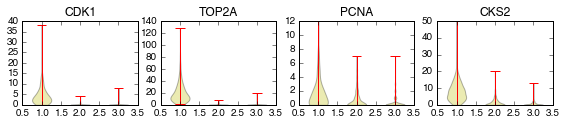

In [12]:
# Violin plot of gene expression of some genes
figure(figsize=(9.5,1.5))
for n,g in enumerate(['CDK1', 'TOP2A', 'PCNA', 'CKS2']):
    subplot(1,4,n+1)
    Y,ymeans = [df.ix[g, res == i].values for i in set(res)], [mean(df.ix[g, res == i]) for i in set(res)]
    violinplot(Y, )
    title(g)
    ylim(0)

In [13]:
cycling_cells_target = (res == argmax(ymeans)).astype(float) # Cluster 3, in red, is chosen as the cycling cells cluster

## Visualy check the separation in PCA space

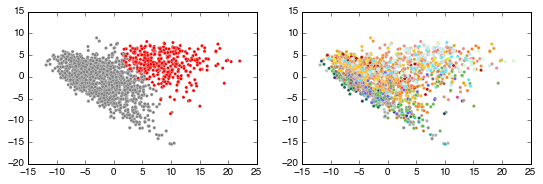

In [14]:
# Visualize on PCA the cluster and the types
figure(figsize=(9,6))
subplot(221)
pca = PCA()
pca.fit(df_norm.T)
pcs = pca.transform(df_norm.T)
scatter(pcs[:,0],pcs[:,1],
        c=['r' if i==argmax(ymeans) else '0.5' for i in res] ,
        s=10, edgecolor='0.9', lw = 0.3)

colors_cells = [map(lambda x: x/256., colors_types[i]) for i in cols_annot.ix['Cell_type',df_norm.columns]]
subplot(222)
scatter(pcs[:,0],pcs[:,1], color=colors_cells, s=10, edgecolor='0.9', lw = 0.3 )

# Fit a L1 Regularized Regression Model

## Evaluate a grid of parameters by Crossvalidation

In [15]:
_, type_indexes = unique(cols_annot.ix['Cell_type',df_log.columns], return_inverse=1)

lassocv = LassoCV(alphas=logspace(-3.5,-0.5,500),fit_intercept=False, positive=True,
                  cv=StratifiedShuffleSplit(type_indexes, n_iter=30, test_size=0.15))
lassocv.fit( df_log.T, cycling_cells_target)

LassoCV(alphas=array([ 0.00032,  0.00032, ...,  0.31188,  0.31623]),
    copy_X=True,
    cv=StratifiedShuffleSplit(labels=[ 5 20 ...,  6  6], n_iter=30, test_size=0.15, random_state=None),
    eps=0.001, fit_intercept=False, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=True, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

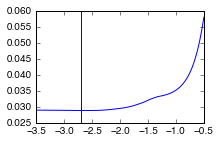

In [16]:
figure(figsize=(3,2))
chos = 0.002 # The reg parameter is chosen to generate a very general model 
axvline(log10(chos))
plot(log10(lassocv.alphas_), lassocv.mse_path_.mean(1))

In [17]:
lasso = Lasso(alpha=chos,max_iter=2000)
lasso.fit(df_log.T, cycling_cells_target)
y1 = lasso.predict(df_log.T)

# Inspect the results

## Visualize the coefficients distribution

26


(-10, 230)

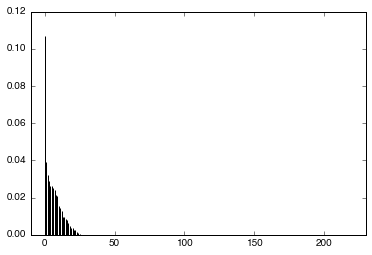

In [18]:
figure(figsize=(6,4))
print (abs(lassocv.coef_)>0).sum()
vlines(arange(lassocv.coef_.shape[0]), 0, sort(lassocv.coef_)[::-1] )
xlim(-10,230)

## Tabulate the top coefficients

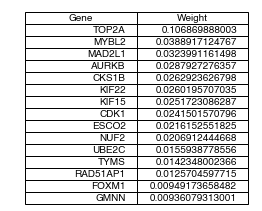

In [19]:
colLabels=("Gene", "Weight")
rows_list = zip( df_norm.index[ argsort( lassocv.coef_ )[::-1] ].tolist()[:15],\
                lassocv.coef_ [argsort( lassocv.coef_ )[::-1] ][:15])
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.001, 2
hpad, wpad = 0, 0    
fig=plt.figure(figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels)

## Visualize the scoring

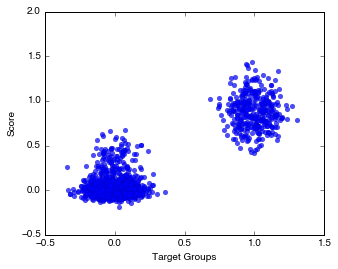

In [22]:
figure(figsize=(5,4))
scatter( cycling_cells_target+random.normal(0,0.1, size=y1.shape), y1, alpha=0.7, s=25, lw=0.1 )
xlabel('Target Groups')
ylabel('Score')

# Overlay the scoring on the PCA

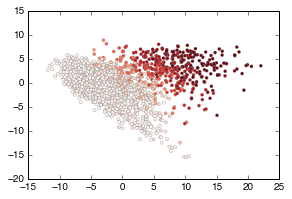

In [21]:
# Visualize the score on the PCA
figure(figsize=(4.5,3))
scatter(pcs[:,0],pcs[:,1], c=cm.Reds(y1),s=10, edgecolor='0.5', lw = 0.3)